In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import seaborn as sns
import datetime
import time

from importlib import reload
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import numba
from multiprocessing.pool import ThreadPool

import simulation as sim

In [3]:
reload(sim)

<module 'simulation' from 'C:\\Users\\Sharp.Ra\\PyProjects\\FinalMDS\\simulation.py'>

## Base model

In [4]:
# parameters of MM (market maker)
gamma = 0.1  # risk-aversion of MM

# parameters of market simulation
L = 210  # market orders per T (Poisson lambda)
alpha = 1.5  # power law distribution of market order volumes
k = 1.5  # coefficient k for lambda(delta) = A * exp(-k*delta), k = alpha*K => K = 1
A = L / alpha  # A = L / A = 140 => L=210

# Time parameters
T = 1  # time horizon
dt = 0.005  # time quant

# Brownian motion parameters
mu = 0.0
sigma = 2  # brownian motion

In [5]:
%%time
df_deals = sim.init_df_deals(start_price=100)
np_deals = sim.simulation_run(df_deals.to_numpy(), gamma, A, k, T, dt, mu, sigma)

Wall time: 3.48 s


In [6]:
df_deals = sim.add_df_deals(df_deals, np_deals)
df_deals[:5]

,Time,Wealth,Inventory,Deal side,Mid,Bid,Ask,R-price,Spread,PnL
1,0.005,0.000000,0,0,99.795351,98.950966,100.639736,99.795351,1.68877,0.000000
2,0.010,0.000000,0,0,100.072241,99.228856,100.915626,100.072241,1.68677,0.000000
3,0.015,-99.113340,1,1,99.955725,99.113340,100.798111,99.955725,1.68477,0.842385
4,0.020,1.470351,0,2,100.134306,98.900921,100.583691,99.742306,1.68277,1.470351
5,0.025,1.470351,0,0,100.234345,99.393960,101.074731,100.234345,1.68077,1.470351


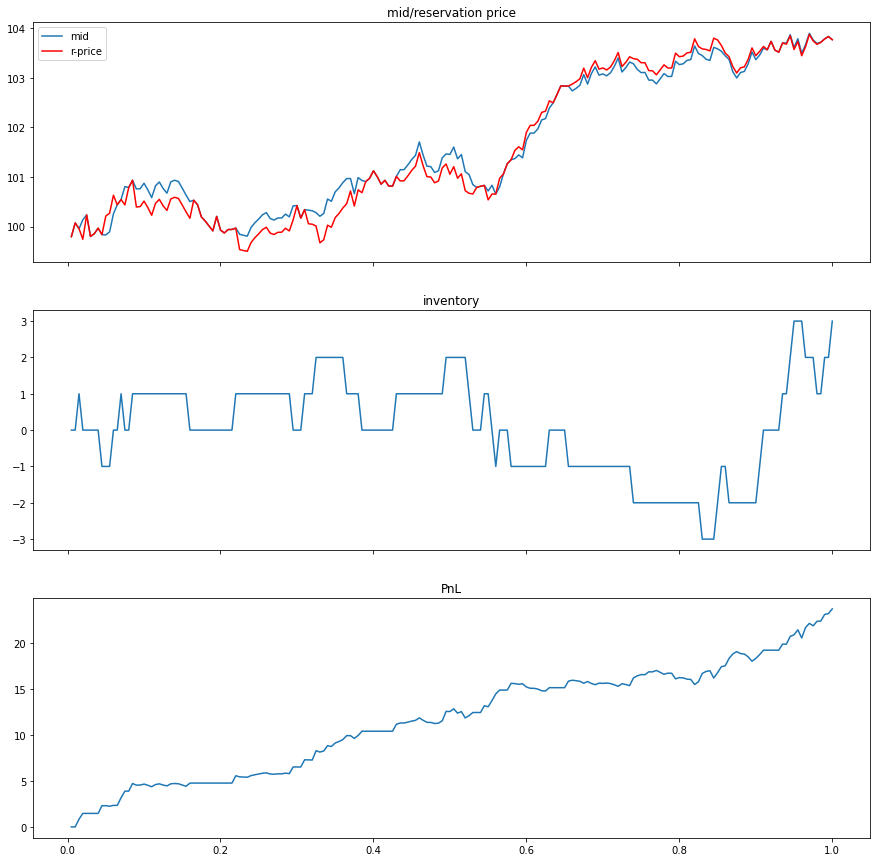

In [7]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

In [8]:
avg_spread = df_deals['Spread'].mean()
avg_spread

1.4897704227514235

In [9]:
df_deals = sim.init_df_deals(start_price=100)
np_deals = sim.simulation_symm_run(df_deals.to_numpy(), avg_spread, avg_spread, A, k, T, dt, mu, sigma)

df_deals = sim.add_df_deals(df_deals, np_deals)
df_deals[:5]

,Time,Wealth,Inventory,Deal side,Mid,Bid,Ask,R-price,Spread,PnL
1,0.005,0.000000,0,0,99.761761,99.016876,100.506646,99.761761,1.48977,0.000000
2,0.010,0.000000,0,0,99.930610,99.185725,100.675495,99.930610,1.48977,0.000000
3,0.015,0.000000,0,0,99.839651,99.094766,100.584536,99.839651,1.48977,0.000000
4,0.020,-99.148657,1,1,99.893542,99.148657,100.638428,99.893542,1.48977,0.744885
5,0.025,-99.148657,1,0,100.011088,99.266203,100.755973,100.011088,1.48977,0.862431


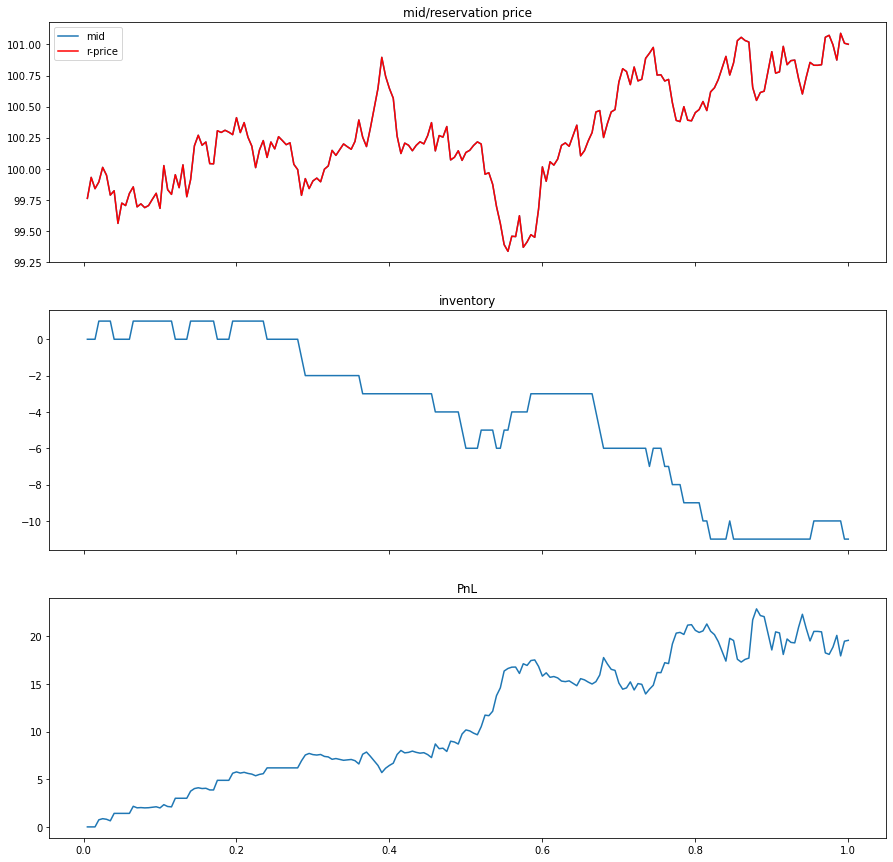

In [10]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

In [11]:
%%time
df_simres = sim.run_sims(1000, start_price=100, gamma=0.1, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma)

Wall time: 2.39 s


In [12]:
df_simres_01 = df_simres.copy()

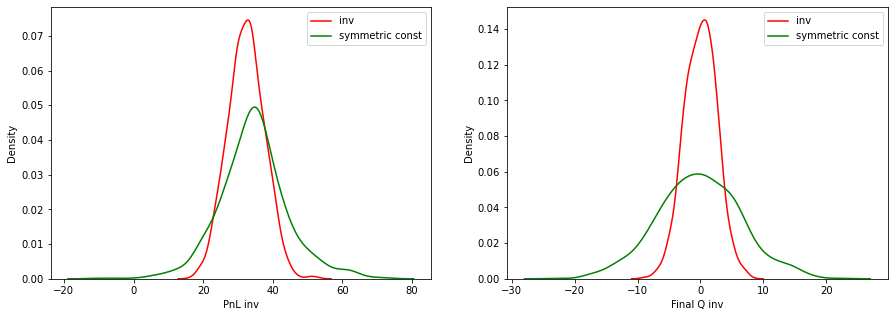

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_simres_01, x='PnL inv', color='r', ax=axes[0], label='inv')
sns.kdeplot(data=df_simres_01, x='PnL const', color='g', ax=axes[0], label='symmetric const')
axes[0].legend()

sns.kdeplot(data=df_simres_01, x='Final Q inv', color='r', ax=axes[1], label='inv')
sns.kdeplot(data=df_simres_01, x='Final Q const', color='g', ax=axes[1], label='symmetric const')
axes[1].legend()


In [14]:
df_simres = sim.run_sims(1000, start_price=100, gamma=1, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma)

In [15]:
df_simres_1 = df_simres.copy()

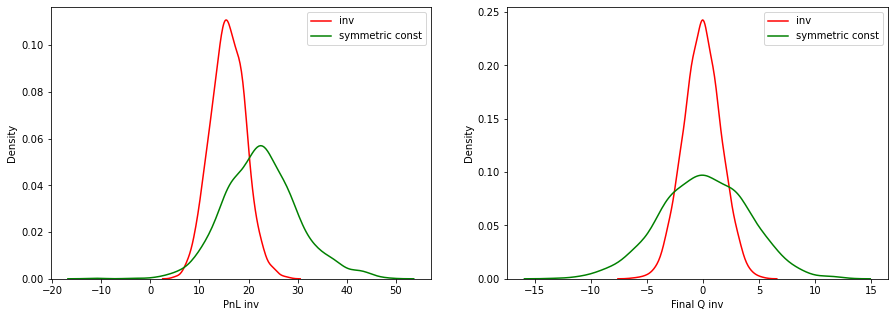

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_simres_1, x='PnL inv', color='r', ax=axes[0], label='inv')
sns.kdeplot(data=df_simres_1, x='PnL const', color='g', ax=axes[0], label='symmetric const')
axes[0].legend()

sns.kdeplot(data=df_simres_1, x='Final Q inv', color='r', ax=axes[1], label='inv', bw_adjust=1.3)
sns.kdeplot(data=df_simres_1, x='Final Q const', color='g', ax=axes[1], label='symmetric const')
axes[1].legend()

## USD/RUB

### Base model for 1 hour horizon

In [17]:
# parameters of MM (market maker)
gamma = 0.1  # risk-aversion of MM

# parameters of market structure
alpha = 2.0  # tail exponent

K = 0.0060  # avg impact = K * log(V)
ticksize = 0.0025

# parameters of market simulation
T = 1  # one hour
dt = 0.5 / 3600  # x seconds (x / 3600)
L = 2200 # number of market orders per T (Poisson lambda)

# coefficient lambda(delta) = A * exp(-k*delta)
k = alpha / K 
A = L / alpha

# Brownian motion parameters (rough estimation)
mu = 0.  # zero drift
sigma = 0.4 * (1/8)**0.5  # brownian motion, daily historical std dev of USD/RUB, convert to hour basis

In [18]:
start_price = 70.

In [19]:
%%time
# Example run
df_deals = sim.init_df_deals(start_price)
np_deals = sim.simulation_run(df_deals.to_numpy(), gamma, A, k, T, dt, mu, sigma, ticksize)
df_deals = sim.add_df_deals(df_deals, np_deals)

Wall time: 1.28 s


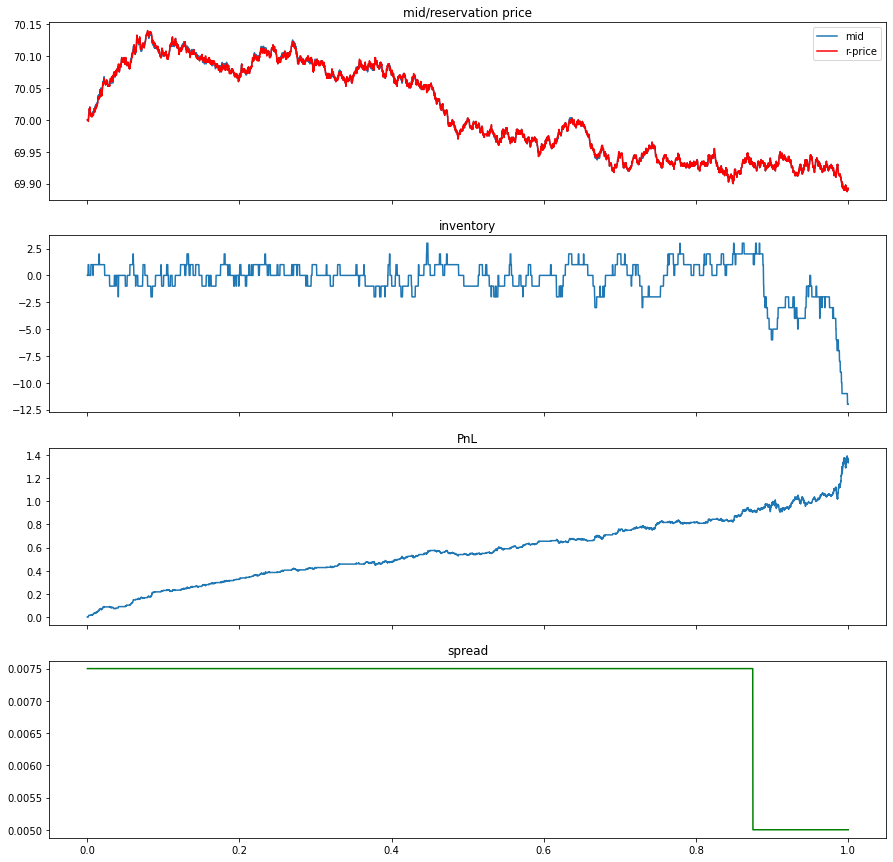

In [20]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

axes[3].plot(df_deals['Time'], df_deals['Spread'], 'g', label='spread')
axes[3].title.set_text('spread')

In [21]:
df_simres = sim.run_sims(1000, start_price=start_price, 
                         gamma=gamma, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma, ticksize=0.0025)

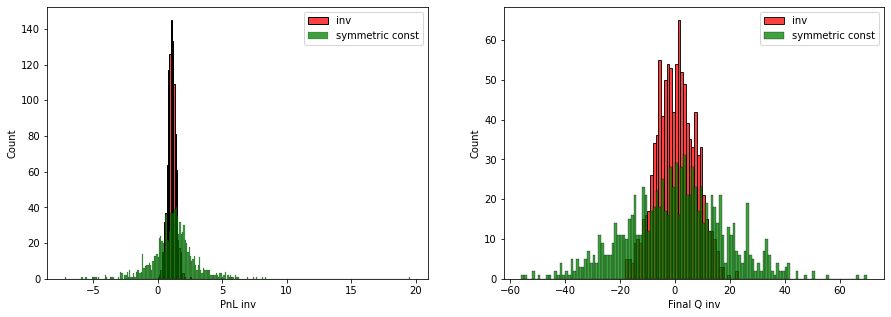

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='PnL inv', color='r', ax=axes[0], label='inv', binwidth=0.1)
sns.histplot(data=df_simres, x='PnL const', color='g', ax=axes[0], label='symmetric const', binwidth=0.1)
axes[0].legend()

sns.histplot(data=df_simres, x='Final Q inv', color='r', ax=axes[1], label='inv', binwidth=1)
sns.histplot(data=df_simres, x='Final Q const', color='g', ax=axes[1], label='symmetric const', binwidth=1)
axes[1].legend()

In [23]:
gamma = 1.
df_simres = sim.run_sims(1000, start_price=start_price, 
                         gamma=gamma, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma, ticksize=0.0025)

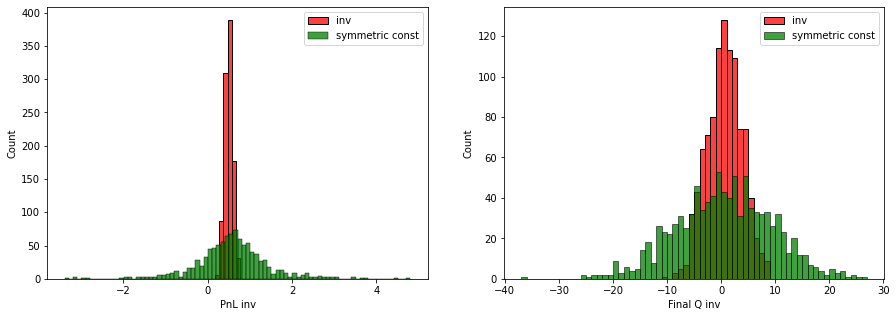

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='PnL inv', color='r', ax=axes[0], label='inv', binwidth=0.1)
sns.histplot(data=df_simres, x='PnL const', color='g', ax=axes[0], label='symmetric const', binwidth=0.1)
axes[0].legend()

sns.histplot(data=df_simres, x='Final Q inv', color='r', ax=axes[1], label='inv', binwidth=1)
sns.histplot(data=df_simres, x='Final Q const', color='g', ax=axes[1], label='symmetric const', binwidth=1)
axes[1].legend()

### Base model for 1 day horizon

In [25]:
# parameters of MM (market maker)
gamma = 0.1  # risk-aversion of MM

# parameters of market structure
alpha = 2  # tail exponent

K = 0.006  # avg impact = K * log(V)
ticksize = 0.0025

# parameters of market simulation
T = 9  # one day
dt = 0.5 / 3600  # x seconds (x / 3600)
L = 2200 # number of market orders per T (Poisson lambda)

# coefficient lambda(delta) = A * exp(-k*delta)
k = alpha / K 
A = L / alpha

# Brownian motion parameters (rough estimation)
mu = 0.  # zero drift
sigma = 0.4 * (1/8)**0.5  # brownian motion, daily historical std dev of USD/RUB, convert to hour basis

In [26]:
start_price = 70.

In [27]:
%%time
# Example run
df_deals = sim.init_df_deals(start_price)
np_deals = sim.simulation_run(df_deals.to_numpy(), gamma, A, k, T, dt, mu, sigma, ticksize)
df_deals = sim.add_df_deals(df_deals, np_deals)

Wall time: 55.1 s


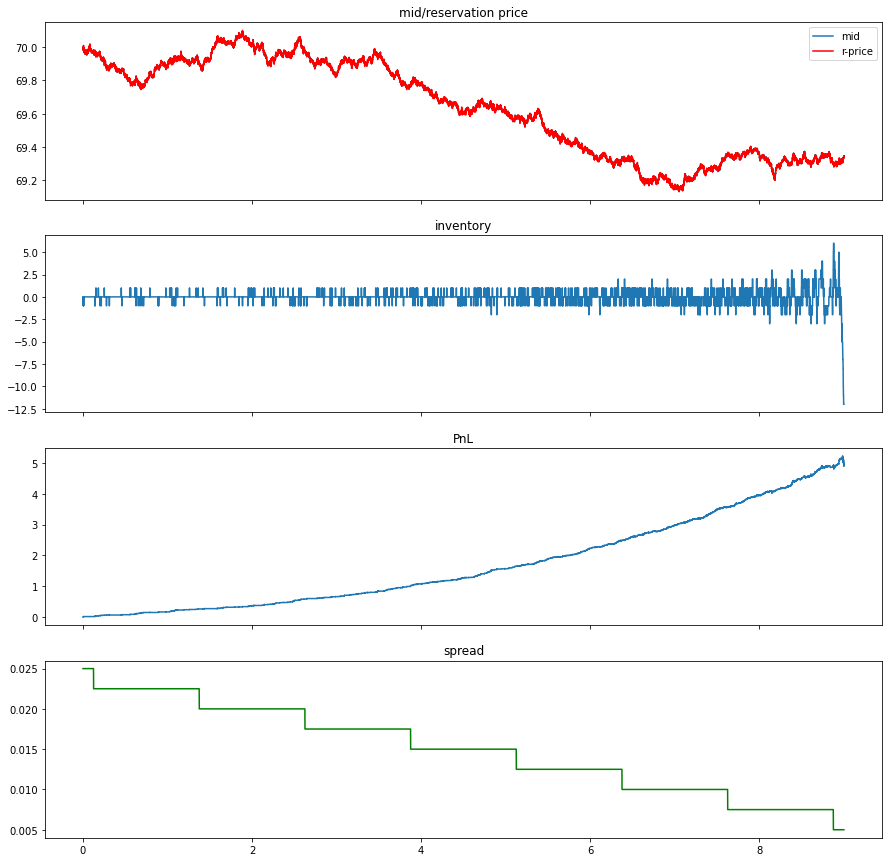

In [28]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

axes[3].plot(df_deals['Time'], df_deals['Spread'], 'g', label='spread')
axes[3].title.set_text('spread')

### 1 day with spread limit

In [29]:
# parameters of MM (market maker)
gamma = 0.1  # risk-aversion of MM

# parameters of market structure
alpha = 2  # tail exponent

K = 0.006  # avg impact = K * log(V)
ticksize = 0.0025
max_spread = 4  # 2x

# parameters of market simulation
T = 9  # one day
dt = 0.5 / 3600  # x seconds (x / 3600)
L = 2000 # number of market orders per T (Poisson lambda)

# coefficient lambda(delta) = A * exp(-k*delta)
k = alpha / K 
A = L / alpha

# Brownian motion parameters (rough estimation)
mu = 0.  # zero drift
sigma = 0.4 * (1/8)**0.5  # brownian motion, daily historical std dev of USD/RUB, convert to hour basis

In [30]:
start_price = 70.

In [31]:
%%time
# Example run
df_deals = sim.init_df_deals(start_price)
np_deals = sim.simulation_run(df_deals.to_numpy(), gamma, A, k, T, dt, mu, sigma, ticksize, max_spread)
df_deals = sim.add_df_deals(df_deals, np_deals)

Wall time: 58.1 s


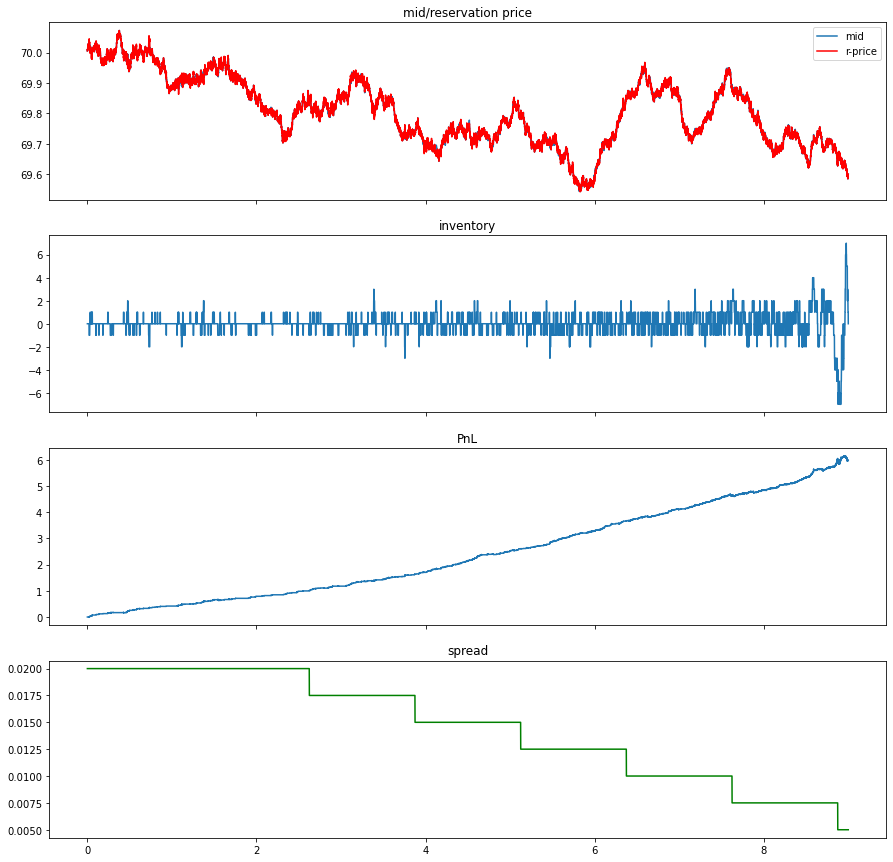

In [32]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

axes[3].plot(df_deals['Time'], df_deals['Spread'], 'g', label='spread')
axes[3].title.set_text('spread')

### Multiperiod 2H model

In [44]:
# parameters of MM (market maker)
gamma = 0.1  # risk-aversion of MM

# parameters of market structure
alpha = 2  # tail exponent
K = 0.0065  # avg impact = K * log(V)
ticksize = 0.0025

# parameters of market simulation
T = 2  # hours
periods = 4  # each period is T
dt = 0.5 / 3600  # x seconds (x / 3600)
L = 2200 # number of market orders per T (Poisson lambda)

# coefficient lambda(delta) = A * exp(-k*delta)
k = alpha / K 
A = L / alpha

# Brownian motion parameters (rough estimation)
mu = 0.  # zero drift
sigma = 0.4 * (1/8)**0.5  # brownian motion, daily historical std dev of USD/RUB, convert to hour basis

In [49]:
start_price = 70.

In [50]:
%%time
# Example run
df_deals = sim.init_df_deals(start_price)
np_deals = sim.sim_multiperiod_run(periods, df_deals.to_numpy(), gamma, A, k, T, dt, mu, sigma, ticksize)
df_deals = sim.add_df_deals(df_deals, np_deals)

Wall time: 4.29 s


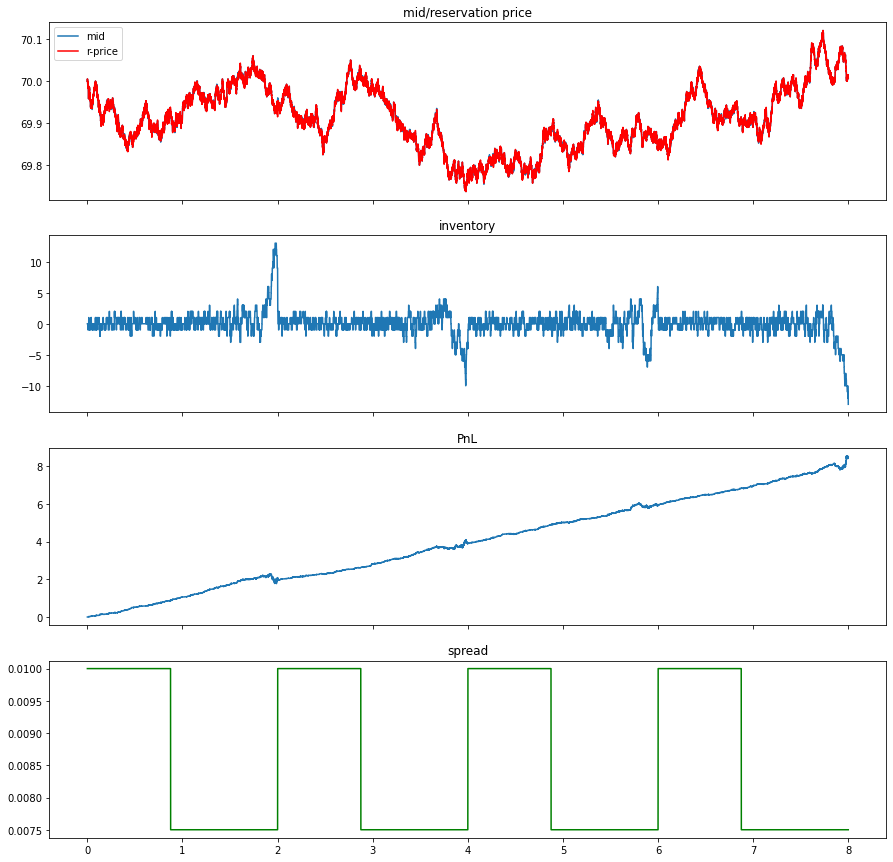

In [51]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

axes[3].plot(df_deals['Time'], df_deals['Spread'], 'g', label='spread')
axes[3].title.set_text('spread')

In [56]:
df_simres = sim.run_multiperiod_sims(500, multiperiod=periods,
                                     start_price=start_price, 
                                     gamma=gamma, A=A, k=k, T=T, dt=dt, mu=mu, sigma=sigma, ticksize=ticksize)

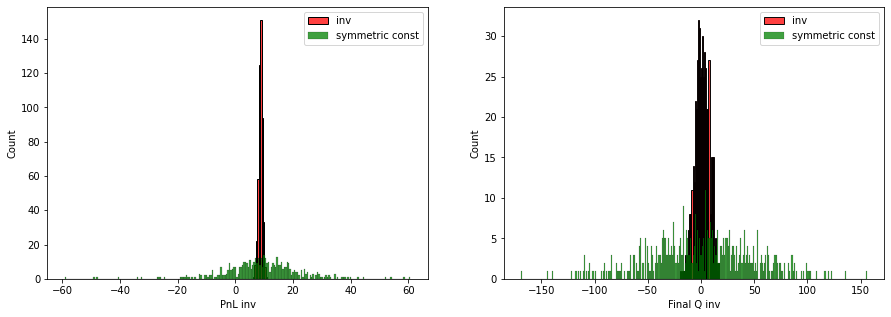

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='PnL inv', color='r', ax=axes[0], label='inv', binwidth=0.5)
sns.histplot(data=df_simres, x='PnL const', color='g', ax=axes[0], label='symmetric const', binwidth=0.5)
axes[0].legend()

sns.histplot(data=df_simres, x='Final Q inv', color='r', ax=axes[1], label='inv', binwidth=1)
sns.histplot(data=df_simres, x='Final Q const', color='g', ax=axes[1], label='symmetric const', binwidth=1)
axes[1].legend()

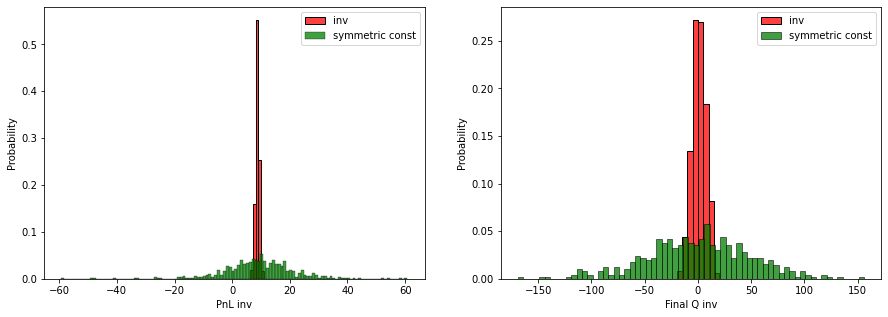

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_simres, x='PnL inv', color='r', ax=axes[0], label='inv', binwidth=1, stat='probability')
sns.histplot(data=df_simres, x='PnL const', color='g', ax=axes[0], label='symmetric const', binwidth=1, stat='probability')
axes[0].legend()

sns.histplot(data=df_simres, x='Final Q inv', color='r', ax=axes[1], label='inv', binwidth=5, stat='probability')
sns.histplot(data=df_simres, x='Final Q const', color='g', ax=axes[1], label='symmetric const', binwidth=5, stat='probability')
axes[1].legend()